In [79]:
!pip install nltk
!pip install keras
!pip install tensorflow

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
import joblib
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/darylmurenzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/darylmurenzi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darylmurenzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
dataset0 = pd.read_csv("input/clickbait_data.csv")

In [82]:
dataset0 = dataset0.rename(columns={"headline": "text", "clickbait": "label"})

print(dataset0.head())
print(dataset0.shape)

                                                text  label
0                                 Should I Get Bings      1
1      Which TV Female Friend Group Do You Belong In      1
2  The New "Star Wars: The Force Awakens" Trailer...      1
3  This Vine Of New York On "Celebrity Big Brothe...      1
4  A Couple Did A Stunning Photo Shoot With Their...      1
(32000, 2)


In [83]:
# pre process text ( remove punctuation, make characters lowercase and do lemmatization )


def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Lowercase the text
    text = text.lower()

    # 2. Remove punctuation using regex
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)

    # 3. Tokenize the text
    words = text.split()

    # 4. Remove stopwords
    words = [word for word in words if word not in stop_words]

    # 5. Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # 6. Join back into a string
    return ' '.join(lemmatized_words)

df = dataset0.copy()

df = df.drop_duplicates()

df["text"] = df["text"].apply(preprocess_text)
print(df.head())

                                                text  label
0                                          get bings      1
1                      tv female friend group belong      1
2      new star war force awakens trailer give chill      1
3  vine new york celebrity big brother fucking pe...      1
4  couple stunning photo shoot baby learning inop...      1


In [84]:
# Train/Test split

train_data, test_data, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42)

# Further split train_data into train/val

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42)


print(train_data.shape)
print(test_data.shape)

(20480,)
(6400,)


In [85]:
# Terms Frequency -  Inverse Document Frequency


vectorizer = TfidfVectorizer(max_features=5000)

X_train = vectorizer.fit_transform(train_data).toarray()
X_val = vectorizer.transform(val_data).toarray()
X_test = vectorizer.transform(test_data).toarray()

In [97]:
def plot_training_history(history, instance_name="Instance"):
    """
    Plots training and validation accuracy & loss for a given model's history.

    Parameters:
    - history: the History object returned by model.fit()
    - instance_name: name to label the plots (e.g., 'Instance 2')
    """
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'{instance_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{instance_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



def plot_logreg_evaluation(model, X_test, y_test, instance_name="Logistic Regression"):
    """
    Plots Confusion Matrix, ROC Curve, and prediction probabilities for a trained logistic regression model.
    """
    # Probabilities and predictions
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs > 0.5).astype(int)

    # === Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{instance_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

    # === ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{instance_name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # === Probability Histogram
    plt.hist(y_probs, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"{instance_name} - Predicted Probability Distribution")
    plt.xlabel("Probability of Class 1")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.show()

In [ ]:
### Base Neural Network with no tuning

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8434 - loss: 0.3580 - val_accuracy: 0.9477 - val_loss: 0.1379
Epoch 2/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9789 - loss: 0.0613 - val_accuracy: 0.9455 - val_loss: 0.1468
Epoch 3/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - loss: 0.0379 - val_accuracy: 0.9416 - val_loss: 0.1789
Epoch 4/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9923 - loss: 0.0232 - val_accuracy: 0.9406 - val_loss: 0.2023
Epoch 5/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9941 - loss: 0.0150 - val_accuracy: 0.9422 - val_loss: 0.2349
Epoch 6/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9958 - loss: 0.0089 - val_accuracy: 0.9410 - val_loss: 0.2634
Epoch 7/7
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9973 - loss: 0.0058 - val_accuracy: 0.9398 - val_loss: 0.2873
Accuracy: 0.9505
F1-score: 0.9508
Recall: 0.9358
Precision: 0.9662


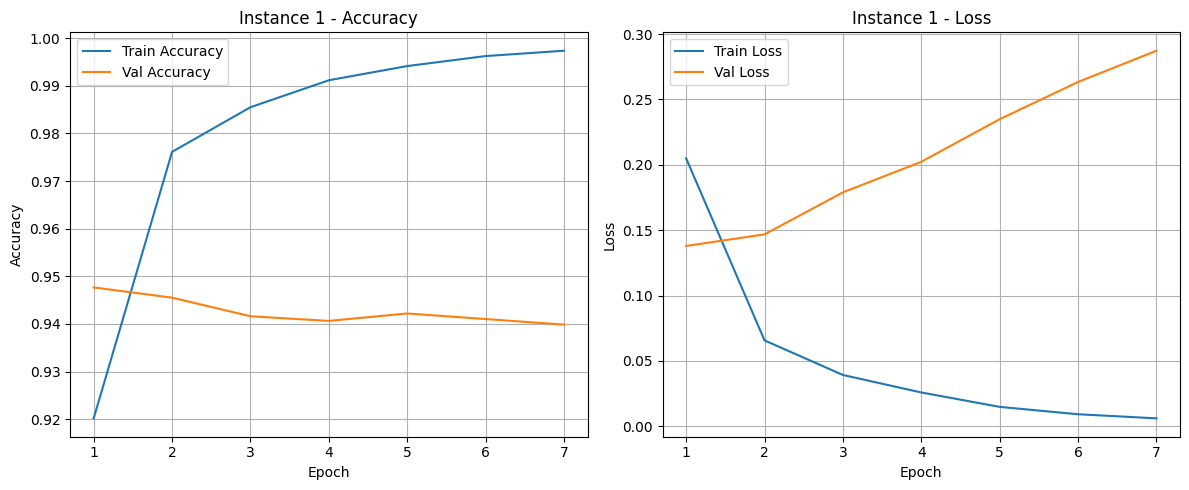

In [87]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# === Compile with default settings (no optimizer tuning)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# === Train model (no early stopping)
history = model.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=7)

accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, zero_division=0)
recall = recall_score(test_labels, y_pred, zero_division=0)
precision = precision_score(test_labels, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plot_training_history(history, instance_name="Instance 1")

In [88]:
model.save("saved_models/base_nn_instance1.h5")
print("Model saved to saved_models/base_nn_instance1.h5")

Model saved to saved_models/base_nn_instance1.h5


In [ ]:
### Model 2 with optimizers, regularizers , drop out and early stopping

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7623 - loss: 1.0689 - val_accuracy: 0.9182 - val_loss: 0.5543
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9210 - loss: 0.5469 - val_accuracy: 0.9293 - val_loss: 0.5177
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9244 - loss: 0.5149 - val_accuracy: 0.9283 - val_loss: 0.5060
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9308 - loss: 0.4909 - val_accuracy: 0.9254 - val_loss: 0.4865
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9308 - loss: 0.4790 - val_accuracy: 0.9293 - val_loss: 0.4786
Epoch 6/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9334 - loss: 0.4685 - val_accuracy: 0.9326 - val_loss: 0.4652
Epoch 7/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9339 - loss: 0.4581 - val_accuracy: 0.9277 - val_loss: 0.4706
Epoch 8/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9342 - loss: 0.4490 - val_accuracy: 0.

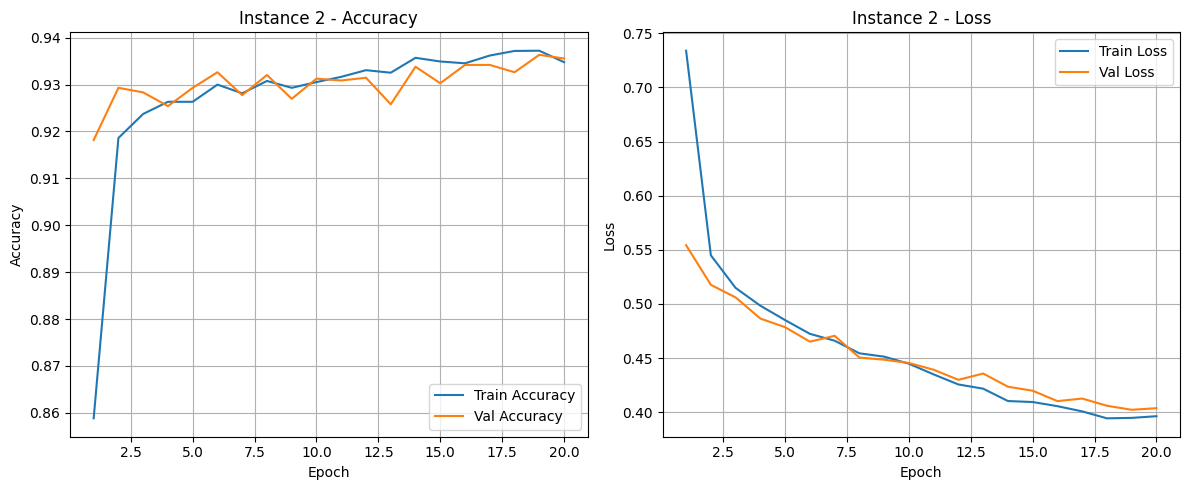

In [89]:
#### build neural network model

# Define model with regularization, dropout, deeper layers
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile with custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with validation and early stopping
history = model.fit(X_train, train_labels, validation_data=(X_val, val_labels), epochs=20, callbacks=[early_stop])


test_tfidf=  vectorizer.transform(test_data).toarray()

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plot_training_history(history, instance_name="Instance 2")

In [90]:
model.save("saved_models/adam_l2_dropout_instance2.h5")
print("Model saved to saved_models/adam_l2_dropout_instance2.h5")

Model saved to saved_models/adam_l2_dropout_instance2.h5


In [ ]:
### Model 3 with optimizers, regularizers , drop out and early stopping

Class weights: {0: np.float64(0.9940782448305989), 1: np.float64(1.0059927301306613)}


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8107 - loss: 0.8195 - val_accuracy: 0.9025 - val_loss: 0.3784
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9043 - loss: 0.3670 - val_accuracy: 0.9080 - val_loss: 0.3380
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9146 - loss: 0.3217 - val_accuracy: 0.9109 - val_loss: 0.3110
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9122 - loss: 0.3022 - val_accuracy: 0.9117 - val_loss: 0.3056
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9155 - loss: 0.2886 - val_accuracy: 0.9105 - val_loss: 0.2962
Epoch 6/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9108 - loss: 0.2899 - val_accuracy: 0.9078 - val_loss: 0.2883
Epoch 7/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9091 - loss: 0.2834 - val_accuracy: 0.9137 - val_loss: 0.2822
Epoch 8/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9167 - loss: 0.2707 - val_accuracy: 0.

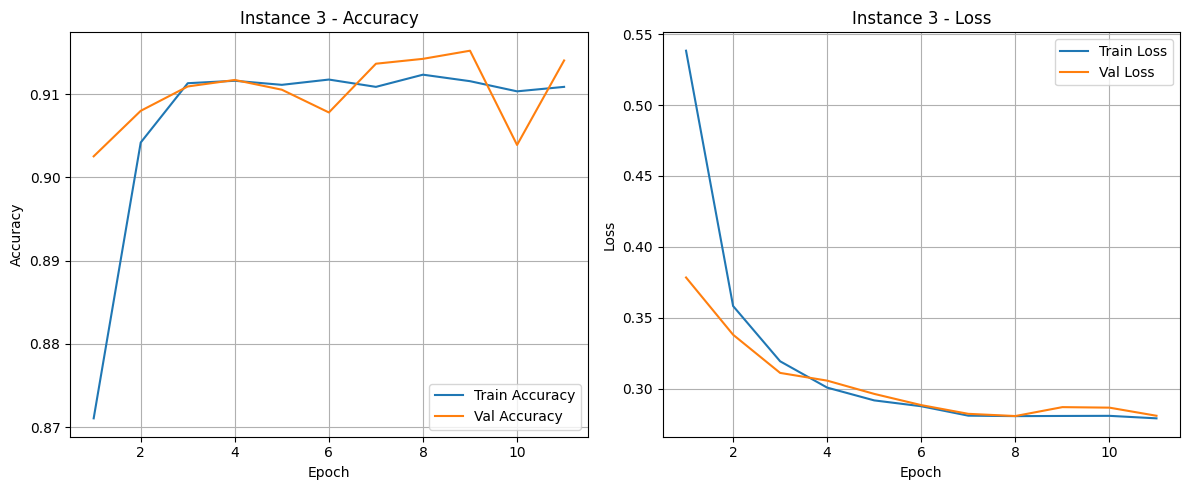

In [91]:
# === Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# === Build the model using L1 regularization ===
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1(0.0001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.0001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# === Compile the model
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# === Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === Train the model
history = model.fit(
    X_train, train_labels,
    validation_data=(X_val, val_labels),
    epochs=20,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# === Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, zero_division=0)
recall = recall_score(test_labels, y_pred, zero_division=0)
precision = precision_score(test_labels, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plot_training_history(history, instance_name="Instance 3")

In [92]:
model.save("saved_models/RMSprop_l1_dropout_instance3.h5")
print("Model saved to saved_models/RMSprop_l1_dropout_instance3.h5")

Model saved to saved_models/RMSprop_l1_dropout_instance3.h5


In [ ]:
### Model 3 with optimizers, regularizers , drop out and early stopping

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5077 - loss: 6.7470 - val_accuracy: 0.5432 - val_loss: 5.9004
Epoch 2/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5352 - loss: 5.6379 - val_accuracy: 0.6490 - val_loss: 4.8842
Epoch 3/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5735 - loss: 4.6527 - val_accuracy: 0.5566 - val_loss: 3.9907
Epoch 4/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6010 - loss: 3.7896 - val_accuracy: 0.7324 - val_loss: 3.2183
Epoch 5/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6413 - loss: 3.0469 - val_accuracy: 0.5459 - val_loss: 2.5658
Epoch 6/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6517 - loss: 2.4245 - val_accuracy: 0.8625 - val_loss: 2.0320
Epoch 7/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6816 - loss: 1.9203 - val_accuracy: 0.8654 - val_loss: 1.6157
Epoch 8/30
640/640 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6973 - loss: 1.5328 - val_accuracy: 0.

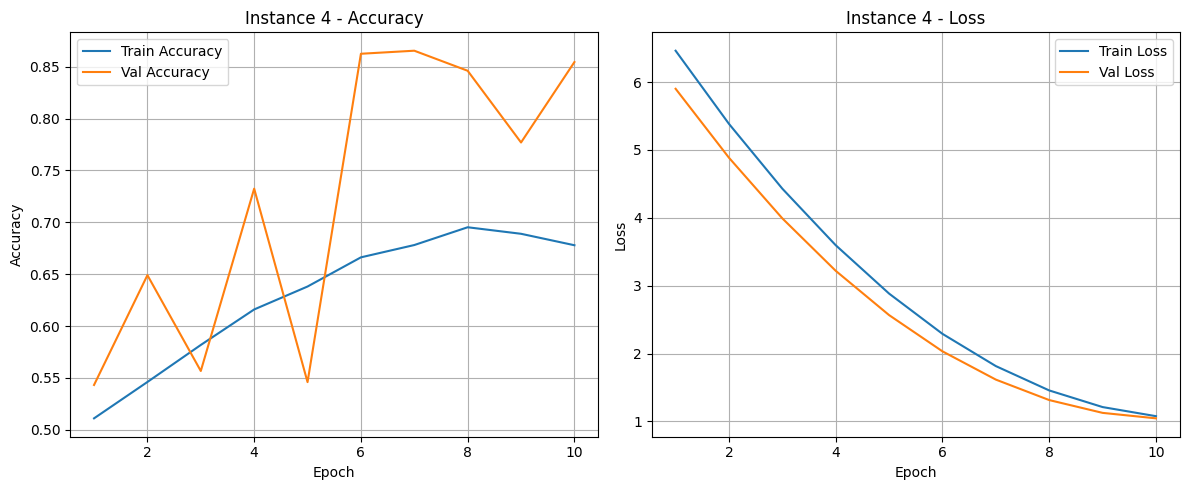

In [98]:

# === Build the model with L1 + L2
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],),
                kernel_regularizer=l1_l2(l1=0.0005, l2=0.001)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu',
                kernel_regularizer=l1_l2(l1=0.0005, l2=0.001)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',
                kernel_regularizer=l1_l2(l1=0.0005, l2=0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # output layer (no regularizer needed)

optimizer = SGD(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# === Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# === Train the model
history = model.fit(
    X_train, train_labels,
    validation_data=(X_val, val_labels),
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# === Evaluate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, zero_division=0)
recall = recall_score(test_labels, y_pred, zero_division=0)
precision = precision_score(test_labels, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plot_training_history(history, instance_name="Instance 4")

In [99]:
model.save("saved_models/SGD_l1_l2_dropout_instance4.h5")
print("Model saved to saved_models/SGD_l1_l2_dropout_instance4.h5")

Model saved to saved_models/SGD_l1_l2_dropout_instance4.h5


In [ ]:
### Final  logistic regression model and hyper-parameter tuning

In [ ]:

# === Build the model
logreg_model = LogisticRegression(
    max_iter=1000,
    C=1.0,  # Lower values = stronger regularization
    solver='liblinear'  # Good for small datasets and binary classification
)

# === Fit the model
logreg_model.fit(X_train, train_labels)

# === Predict
y_pred = logreg_model.predict(X_test)

# === Evaluate
accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, zero_division=0)
recall = recall_score(test_labels, y_pred, zero_division=0)
precision = precision_score(test_labels, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

plot_logreg_evaluation(logreg_model, X_test, test_labels, instance_name="Logistic Regression")

Accuracy: 0.9505
F1-score: 0.9508
Recall: 0.9358
Precision: 0.9662


In [ ]:
joblib.dump(logreg_model, "saved_models/logreg_model.pkl")
print("Model saved to saved_models/logreg_model.pkl'")